In [1]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install seaborn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sb

In [4]:
load = pd.read_csv("CDC_2021.csv", low_memory = False)
df_fill_na = load.replace(r'^\s*$', np.nan, regex=True)
df = df_fill_na.dropna()
df = df.applymap(str)
names = ['SEXVAR', 'CHECKUP1', 'EXERANY2', 'TOLDHI3', 'CVDINFR4', 'CVDSTRK3', 'ASTHMA3', 'CHCOCNCR', 'CHCKDNY2', 'DIABETE4', 'DECIDE', 'DIFFWALK', 'SMOKE100', 'ECIGNOW1', 'ALCDAY5', '@_PHYS14D', '@_MENT14D', '@_AGEG5YR', 'HTM4', 'WTKG3', '@_FRTLT1A', '@_VEGLT1A']
for name in names:
    df = df.drop(df[df[name] == '7'].index)
    df = df.drop(df[df[name] == '9'].index)
    if name == 'CHECKUP1':
        df = df.drop(df[df[name] == '8'].index)
    elif name == 'ALCDAY5':
        df = df.drop(df[df[name] == '777'].index)
        df = df.drop(df[df[name] == '999'].index)
        
        df[name] = df[name].replace(['%s' % i for i in range(100, 108)],'1')
        df[name] = df[name].replace(['%s' % i for i in range(200, 231)],'1')
        df[name] = df[name].replace('888','0')
    elif name == 'DIABETE4':
        df = df.drop(df[df[name] == '2'].index)
        df = df.drop(df[df[name] == '4'].index)
        df[name] = df[name].replace('3','0')
    elif name == 'CVDINFR4':
        df[name] = df[name].replace('1','0')
        df[name] = df[name].replace('2','1')


df = df.drop([ 'PRIMINSR'], axis=1)
new_df = df.groupby('CVDINFR4').sample(n=10000)

In [5]:
X = np.array(new_df.drop("CVDINFR4", axis=1)).astype(np.float32)
y = np.array(new_df["CVDINFR4"]).astype(np.float32).flatten()

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)

print(X_train.shape)

(15000, 21)


In [6]:
model = Sequential([
    BatchNormalization(),
    Dense(21, activation = 'elu', name = 'first_layer'),
    Dense(7, activation = 'selu', name = 'second_layer'),
    Dense(2, activation = 'softmax', name = 'last_layer')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(0.01), 
    metrics = ['accuracy']
)

model.fit(

    X_train,y_train,
    epochs= 50
)

2022-10-15 02:27:36.925097: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-15 02:27:36.925925: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 02:27:37.020331: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
469/469 [==============================] - 1s 783us/step - loss: 0.5479 - accuracy: 0.7235
Epoch 2/50
469/469 [==============================] - 0s 998us/step - loss: 0.5291 - accuracy: 0.7364
Epoch 3/50
469/469 [==============================] - 0s 769us/step - loss: 0.5159 - accuracy: 0.7450
Epoch 4/50
469/469 [==============================] - 0s 799us/step - loss: 0.5144 - accuracy: 0.7522
Epoch 5/50
469/469 [==============================] - 0s 791us/step - loss: 0.5167 - accuracy: 0.7487
Epoch 6/50
469/469 [==============================] - 0s 793us/step - loss: 0.5169 - accuracy: 0.7447
Epoch 7/50
469/469 [==============================] - 0s 794us/step - loss: 0.5270 - accuracy: 0.7342
Epoch 8/50
469/469 [==============================] - 1s 1ms/step - loss: 0.5143 - accuracy: 0.7458
Epoch 9/50
469/469 [==============================] - 0s 828us/step - loss: 0.5151 - accuracy: 0.7470
Epoch 10/50
469/469 [==============================] - 0s 799us/step - loss: 0.5188 

In [7]:
model.evaluate(X_test, y_test)
model.summary()

157/157 [==============================] - 0s 733us/step - loss: 0.5074 - accuracy: 0.7504
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 21)                84        
_________________________________________________________________
first_layer (Dense)          (None, 21)                462       
_________________________________________________________________
second_layer (Dense)         (None, 7)                 154       
_________________________________________________________________
last_layer (Dense)           (None, 2)                 16        
Total params: 716
Trainable params: 674
Non-trainable params: 42
_________________________________________________________________


Text(33.0, 0.5, 'Truth')

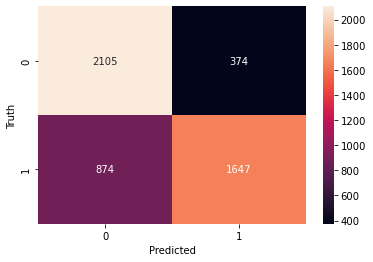

In [8]:
y_prediction = model.predict(X_test)
confuse = []
for i in range (len(X_test)):
    confuse.append(np.argmax(y_prediction[i]))
conf_matrix = np.array(tf.math.confusion_matrix(labels=y_test, predictions=confuse))
sb.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

0.7494


Text(33.0, 0.5, 'Truth')

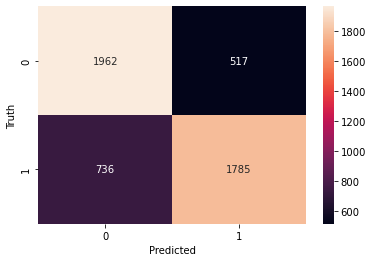

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf = RandomForestClassifier(max_depth=12, random_state=150)
rf.fit(X_train, y_train)

rfcm = confusion_matrix(y_test, rf.predict(X_test).flatten())
print(rf.score(X_test, y_test))

sb.heatmap(rfcm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

0.7464


Text(33.0, 0.5, 'Truth')

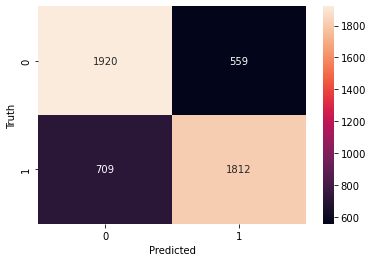

In [10]:
import xgboost as xgb

xg = xgb.XGBClassifier(random_state=1000).fit(X_train, y_train)

xgcm = confusion_matrix(y_test, xg.predict(X_test).flatten())
print(xg.score(X_test, y_test))

sb.heatmap(xgcm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

XGBoost has the highest true positive while neural network has highest true negative